# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [9]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 10

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [10]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [11]:
# Dataset Preprossesing
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


C:\Users\HP\AppData\Local\Temp\ipykernel_14832\3758904839.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
C:\Users\HP\AppData\Local\Temp\ipykernel_14832\3758904839.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


In [12]:
# Neural-Network Initialization
#torch.manual_seed(GROUP_NUMBER)

# Input layer(300 data points) - hidden layer 1
w1 = torch.randn(2, 16)
b1 = torch.randn(16)

# hidden layer 1 - 2
w2 = torch.randn(16, 16)
b2 = torch.randn(16)

# hidden layer 2 - 3
w3 = torch.randn(16, 16)
b3 = torch.randn(16)

# hidden layer 3 - output layer
w4 = torch.randn(16, 2)
b4 = torch.randn(2)

In [13]:
def softmax(z):
  z = z - torch.max(z, dim=1, keepdim=True).values
  exp_z = torch.exp(z)
  return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

# Training Loop
learning_rate = 0.01

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1000):
  z1 = torch.matmul(X_train, w1) + b1
  a1 = torch.relu(z1)

  z2 = torch.matmul(a1, w2) + b2
  a2 = torch.relu(z2)

  z3 = torch.matmul(a2, w3) + b3
  a3 = torch.relu(z3)

  z4 = torch.matmul(a3, w4) + b4
  a4 = softmax(z4)

  # calculating the loss
  y_onehot = torch.zeros_like(a4)
  y_onehot[torch.arange(y_train.shape[0]), y_train.squeeze()] = 1

  loss = -torch.mean(torch.sum(y_onehot*torch.log(a4 + 1e-8), dim=1))
  train_losses.append(loss.item())

  train_pred = torch.argmax(a4, dim=1)
  train_acc = (train_pred == y_train.squeeze()).float().mean().item()
  train_accuracies.append(train_acc)

  # gradient descent
  dz4 = (a4 - y_onehot) / y_train.shape[0]
  dw4 = torch.matmul(a3.T, dz4)
  db4 = torch.sum(dz4, dim=0)

  # hidden layer 3
  da3 = torch.matmul(dz4, w4.T)
  dz3 = da3*(z3>0).float()
  dw3 = torch.matmul(a2.T, dz3)
  db3 = torch.sum(dz3, dim=0)

  # hidden layer 2
  da2 = torch.matmul(dz3, w3.T)
  dz2 = da2*(z2>0).float()
  dw2 = torch.matmul(a1.T, dz2)
  db2 = torch.sum(dz2, dim=0)

  # hidden layer 1
  da1 = torch.matmul(dz2, w2.T)
  dz1 = da1*(z1>0).float()
  dw1 = torch.matmul(X_train.T, dz1)
  db1 = torch.sum(dz1, dim=0)


  with torch.no_grad():
    w4 -= learning_rate * dw4
    b4 -= learning_rate * db4
    w3 -= learning_rate * dw3
    b3 -= learning_rate * db3
    w2 -= learning_rate * dw2
    b2 -= learning_rate * db2
    w1 -= learning_rate * dw1
    b1 -= learning_rate * db1

  # Validation Pass
  with torch.no_grad():
    z1 = torch.matmul(X_test, w1) + b1
    a1 = torch.relu(z1)
    z2 = torch.matmul(a1, w2) + b2
    a2 = torch.relu(z2)
    z3 = torch.matmul(a2, w3) + b3
    a3 = torch.relu(z3)
    z4 = torch.matmul(a3, w4) + b4
    a4 = softmax(z4)

    y_val_onehot = torch.zeros_like(a4)
    y_val_onehot[torch.arange(y_test.shape[0]), y_test.squeeze()] = 1

    val_loss = -torch.mean(torch.sum(y_val_onehot*torch.log(a4 + 1e-8), dim=1))
    val_losses.append(val_loss.item())

    val_pred = torch.argmax(a4, dim=1)
    val_acc = (val_pred == y_test.squeeze()).float().mean().item()
    val_accuracies.append(val_acc)

In [14]:
# Testing / Validation
z1 = torch.matmul(X_test, w1) + b1
a1 = torch.relu(z1)

z2 = torch.matmul(a1, w2) + b2
a2 = torch.relu(z2)

z3 = torch.matmul(a2, w3) + b3
a3 = torch.relu(z3)

z4 = torch.matmul(a3, w4) + b4
a4 = softmax(z4)

accuracy is : 0.9033333333333333, training loss is : 0.3435702919960022, val loss is : 0.33277177810668945


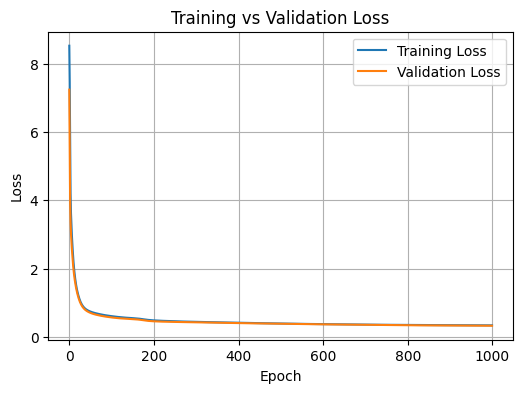

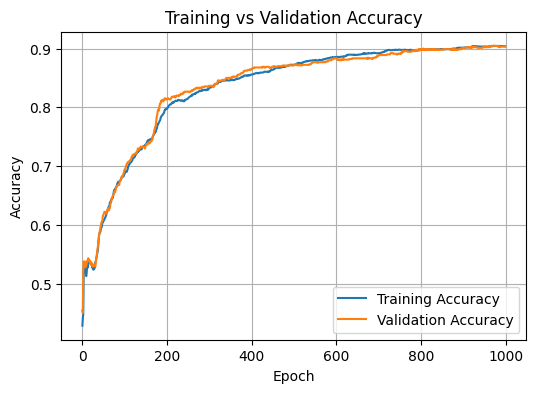

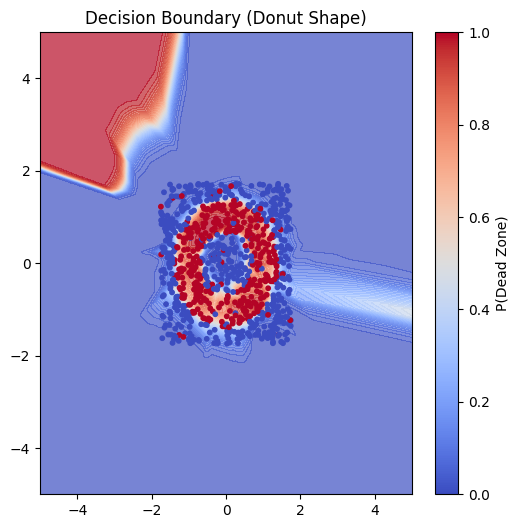

In [15]:
# Predictions and results
_, predicted = torch.max(a4, 1)

accuracy = (predicted == y_test.squeeze()).float().sum().item() / y_test.size(0)

y_test_onehot = torch.zeros_like(a4)
y_test_onehot[torch.arange(y_test.shape[0]), y_test.squeeze()] = 1

val_loss = -torch.mean(torch.sum(
    y_test_onehot * torch.log(a4 + 1e-8),
    dim=1
))

print(f"accuracy is : {accuracy}, training loss is : {loss}, val loss is : {val_loss}")

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy curve
plt.figure(figsize=(6,4))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Decision Boundary Map
xx, yy = np.meshgrid(
    np.linspace(-5, 5, 300),
    np.linspace(-5, 5, 300)
)

grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

z1 = torch.matmul(grid, w1) + b1
a1 = torch.relu(z1)
z2 = torch.matmul(a1, w2) + b2
a2 = torch.relu(z2)
z3 = torch.matmul(a2, w3) + b3
a3 = torch.relu(z3)
z4 = torch.matmul(a3, w4) + b4
a4 = softmax(z4)[:, 1].reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, a4, levels=50, cmap='coolwarm', alpha=0.7)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test.squeeze(), s=10, cmap='coolwarm')
plt.colorbar(label="P(Dead Zone)")
plt.title("Decision Boundary (Donut Shape)")
plt.show()


